In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline, make_pipeline

plt.rcParams['figure.dpi'] = 300
infile = "/content/dati_climate.csv"
df = pd.read_csv(infile, sep=';')
plt.rcParams['figure.dpi'] = 300

print(df['outcome'].value_counts())

features = np.asarray(['vconst_corr', 'vconst_2', 'vconst_3' ,'vconst_4', 'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus',
            'slm_corr', 'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale', 'convect_corr',  'bckgrnd_vdc1',
            'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim', 'Prandtl' ])



X = df.loc[:, features].values
y = df['outcome'].values


# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


print("Counts of label '1': {}".format(sum(y_train == 1))) # counts of label '1' : 346
print("Counts of label '0': {} \n".format(sum(y_train == 0))) # counts of label '0' : 32

1    494
0     46
Name: outcome, dtype: int64
Counts of label '1': 346
Counts of label '0': 32 



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.svm import SVC
kf = KFold(n_splits=5,  shuffle=False)


imba_pipeline = make_pipeline(StandardScaler(),
                              SMOTE(random_state=42),
                              SVC(probability =  True, random_state=42))

params = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 1e-4],
                     'svc__C': [1, 10, 100, 1000]},
                    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000]}]

#new_params = {'svm__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, params, scoring='accuracy', cv=kf,
                        return_train_score=True)


grid_imba.fit(X_train, y_train)
print('Accuracy: {:.4}, with best params: {}'.format(grid_imba.best_score_, grid_imba.best_params_))
# Accuracy: 0.9154, with best params: {'svc__C': 10, 'svc__kernel': 'linear'}

In [3]:
predictions = grid_imba.predict(X_test)
score = grid_imba.score(X_test, y_test)
print('Accuracy on the test set: ')
print(score)

Accuracy on the test set: 
0.9444444444444444


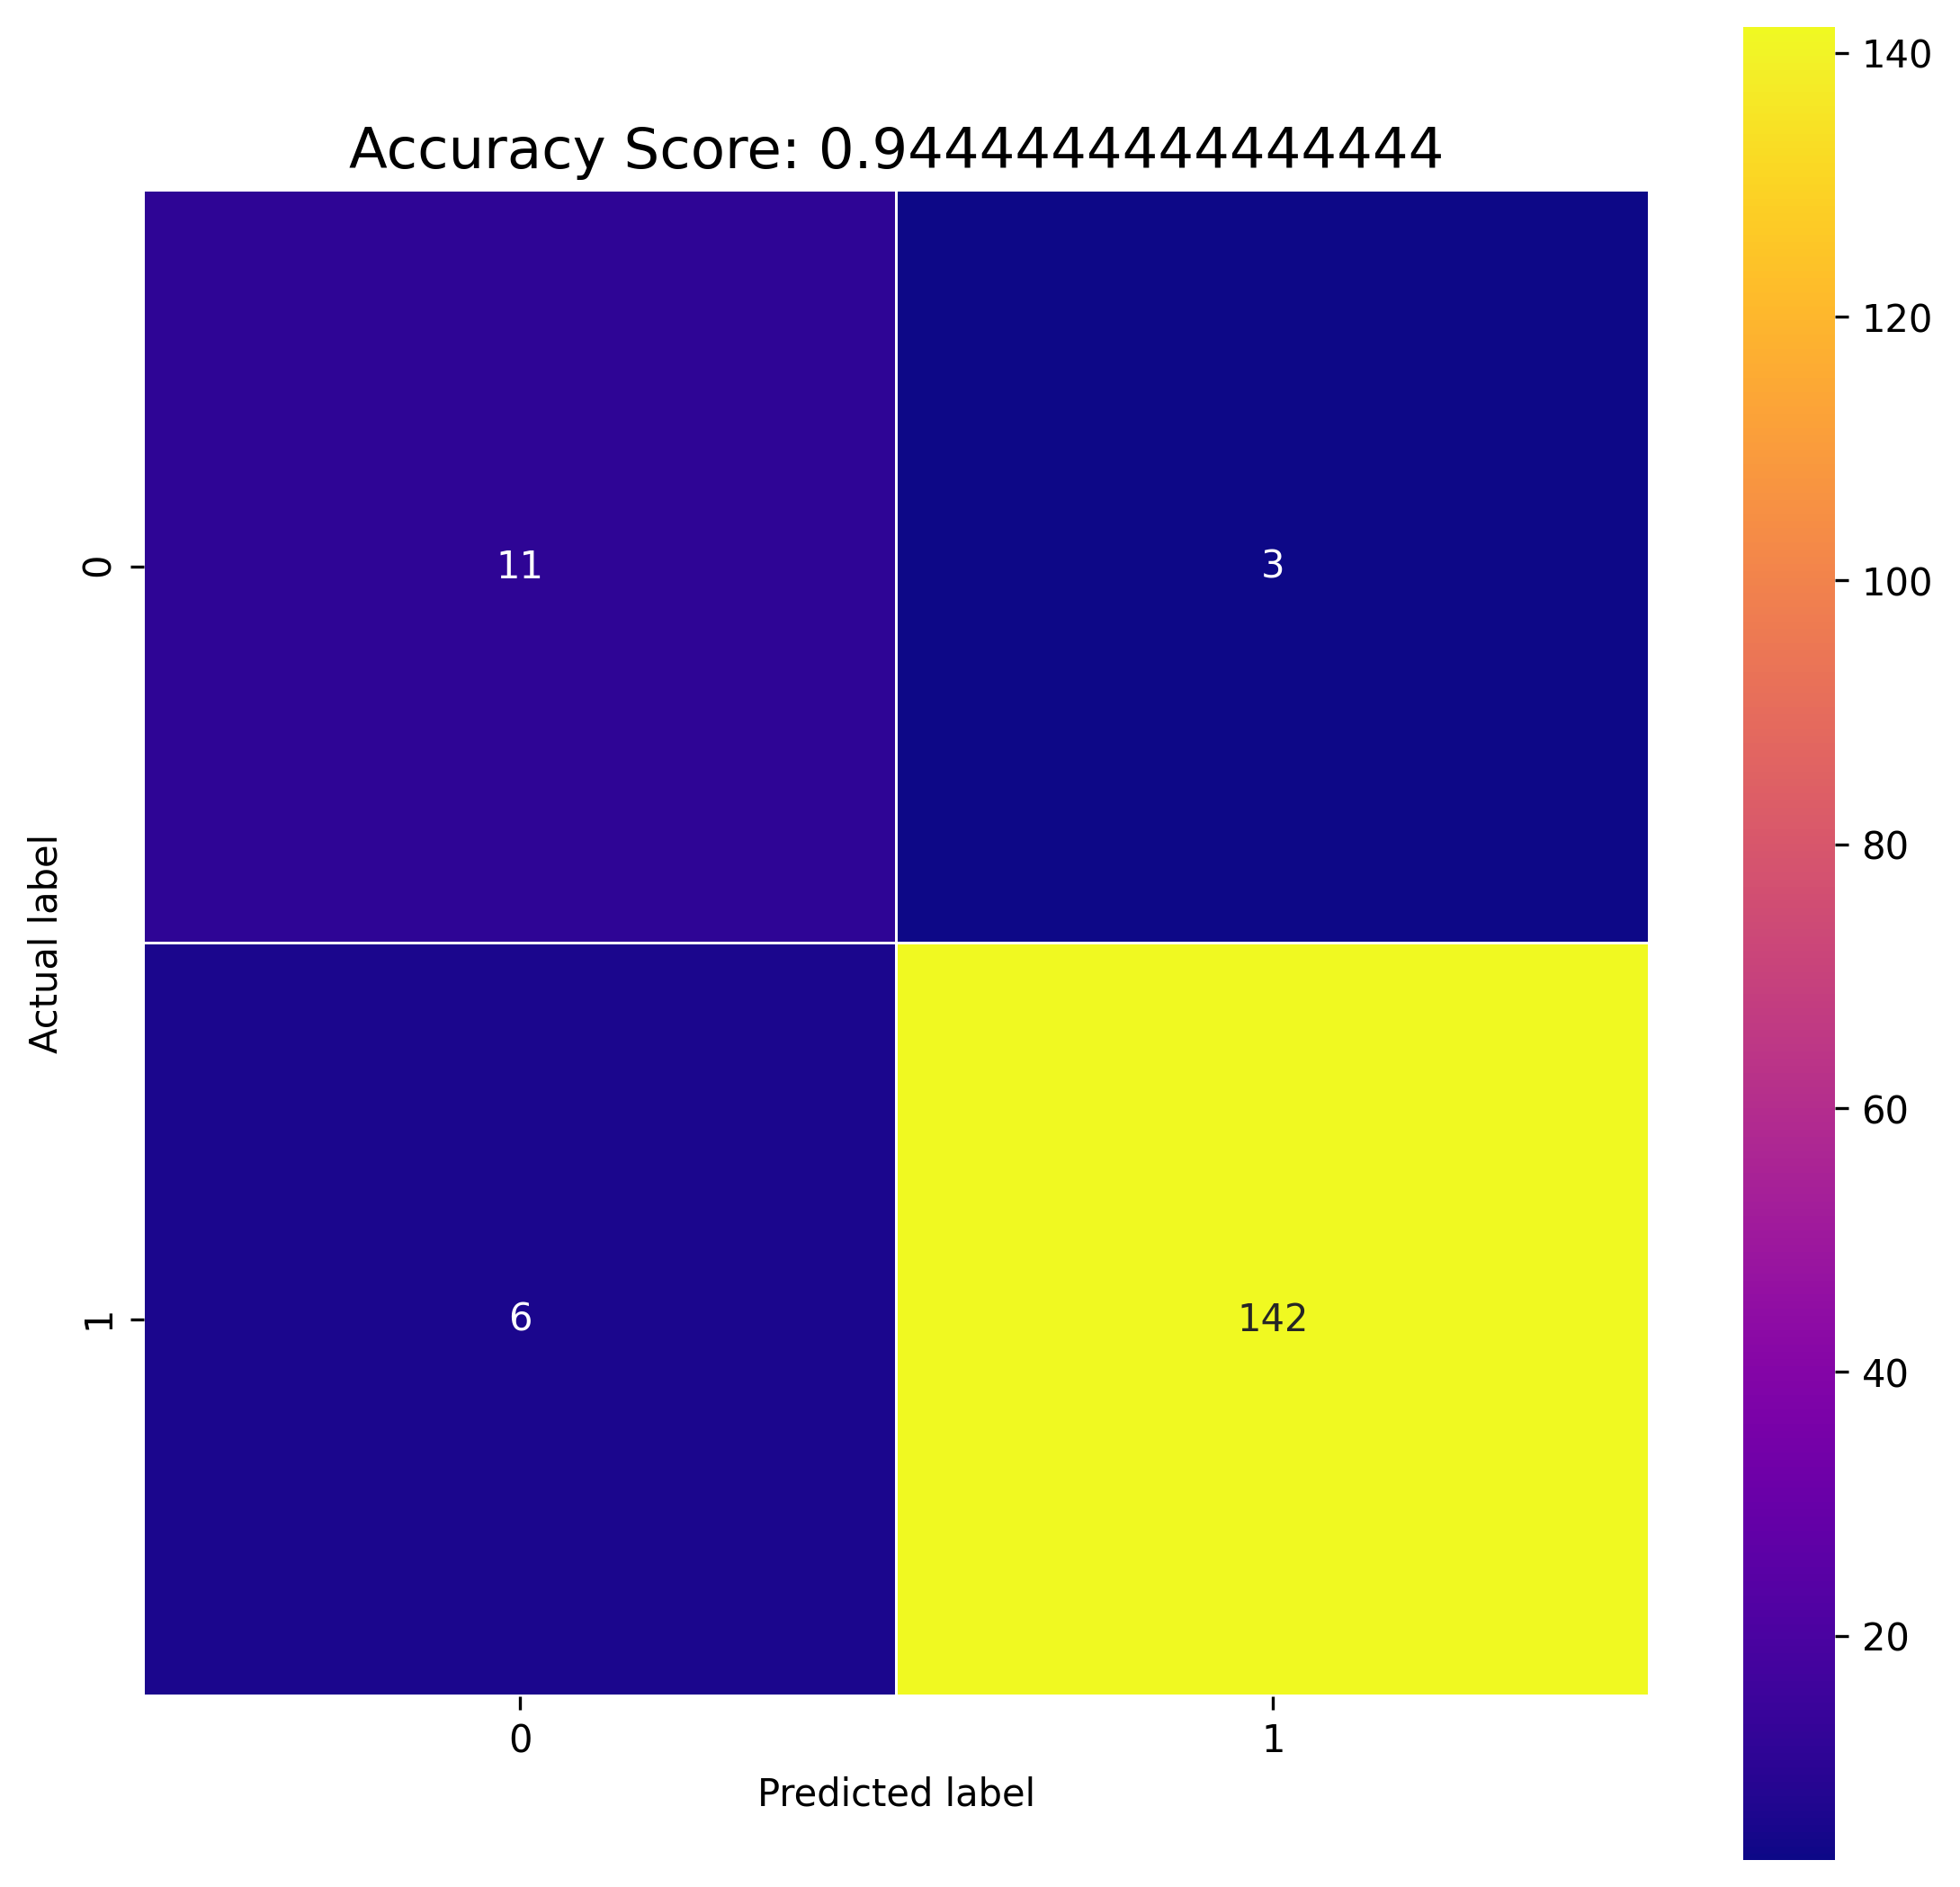

In [5]:
#plot della confusion matrix
plt.rcParams['figure.dpi'] = 300
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'plasma');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.975


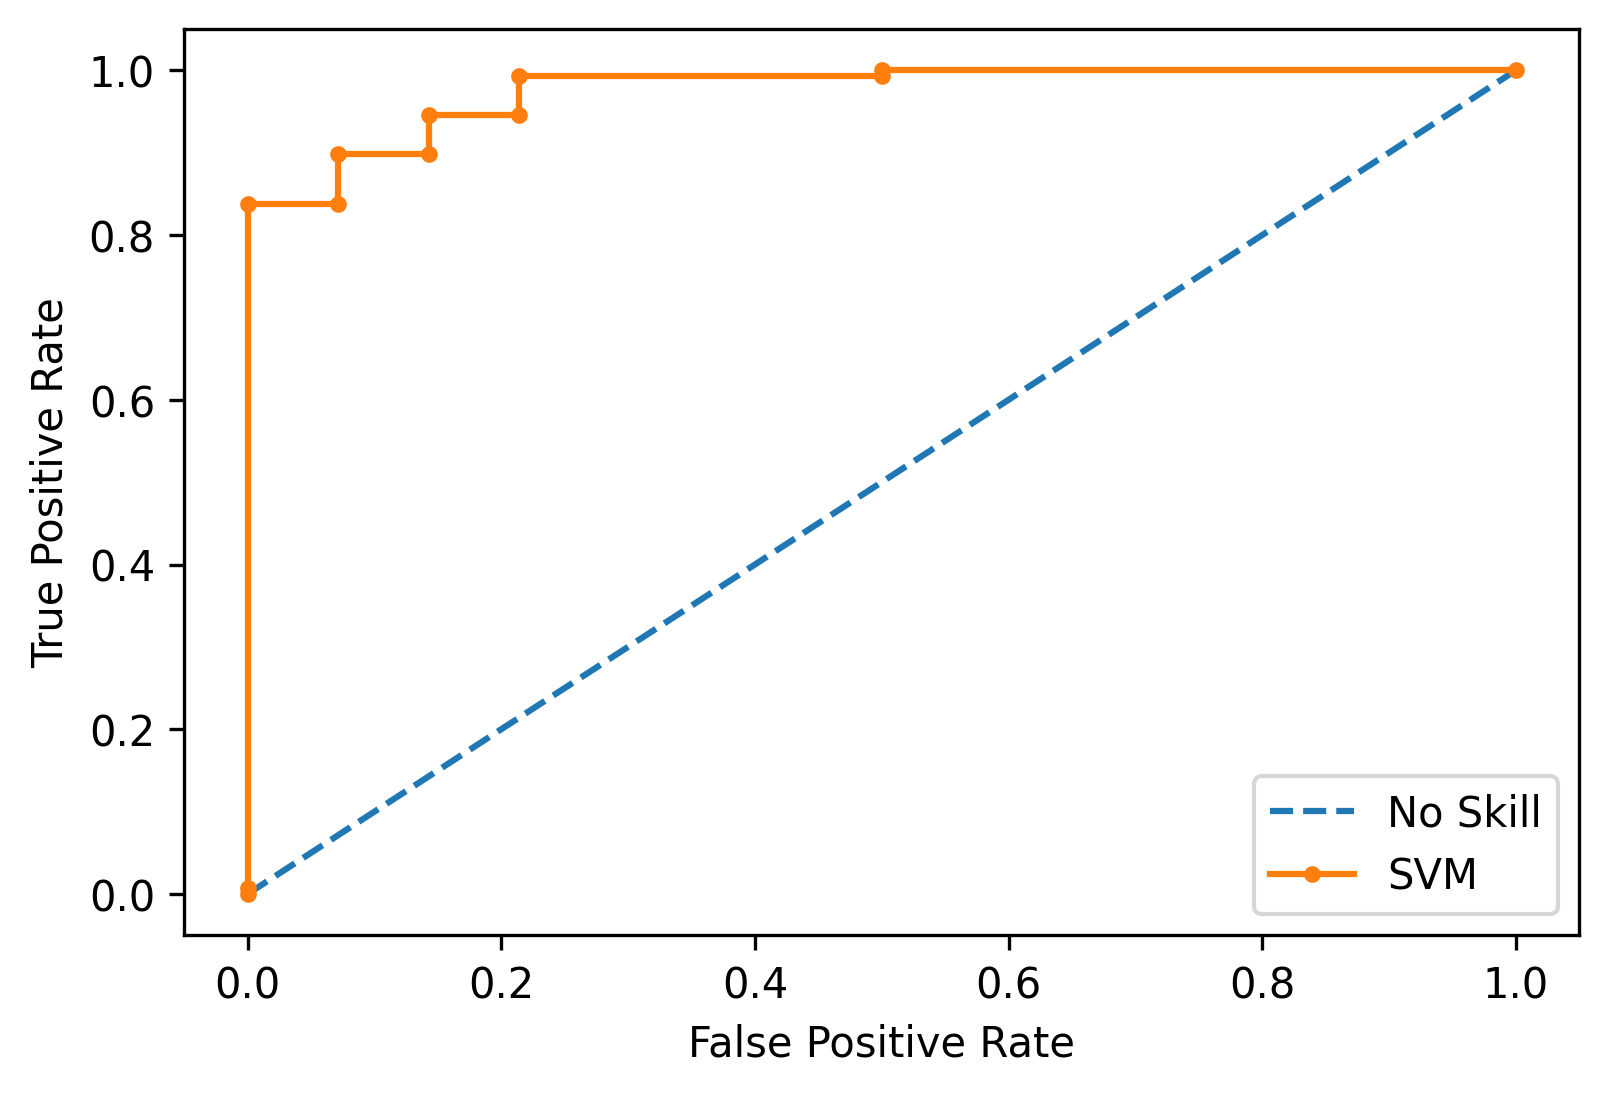

In [6]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
plt.rcParams['figure.dpi'] = 300
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = grid_imba.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()